### Import Packages


In [1]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.12.1+cu113


### Import your drive's contents!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Check if the drive has been mounted well.
# !ls ./drive -> What would happen?
model_dir = './drive/MyDrive/Codes/models'

Mounted at /content/drive


### MNIST dataset is provided in default

In [3]:
train_path = './sample_data/mnist_train_small.csv'
test_path = './sample_data/mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [4]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28**2 for image


In [5]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in tqdm(mnist_reader):
            img = np.array(row[1:], dtype=np.uint16).reshape(img_size, img_size) # from second index : pixel value
            img = img / 255
            label = int(row[0]) # first index : label

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)
    
    return total_img, total_label

In [8]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

print(train_img.shape)

# Let's try to reduce the number of data we have.
train_img = train_img[::5] # 0th, 5th, 10th, ... images! -> 20000/5 num of imgs are selected
train_label = train_label[::5]
test_img = test_img[::5]
test_label = test_label[::5]
print(train_img.shape)
print(test_img.shape)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

(20000, 28, 28)
(4000, 28, 28)
(2000, 28, 28)


### Define the Dataset

In [10]:
class MNIST_Dataset(Dataset):
    def __init__(self, target_img, target_label):
        '''
        target_img : train/test images
        target_label : train/test images
        '''
        self.target_img = target_img # (N, 28, 28)
        self.target_label = target_label # (N,)
        self.num_data = len(target_img)

    def __len__(self):
        return self.num_data
        
    def __getitem__(self, idx):
        curr_img = self.target_img[idx] # (28,28)
        curr_label = self.target_label[idx]

        sample = dict()
        sample['img'] = curr_img
        sample['label'] = curr_label
        
        return sample

### Define the DataLoader

In [11]:
batch_size = 256

# Define dataset instance for train/test
train_dataset = MNIST_Dataset(train_img, train_label)
test_dataset = MNIST_Dataset(test_img, test_label)

# Define dataloader for train/test
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test에는 shuffle 필요 없음

### Try to sample out one data point from dataloader

In [12]:
# Sampling from datalosder
sample = next(iter(test_dataloader))
# Check data's dimension!
print(sample['img'].shape) # (batch_size, img_size, img_size)
print(sample['label'].shape) # (batch_size)

torch.Size([256, 28, 28])
torch.Size([256])


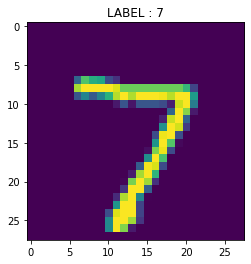

In [13]:
# Try to plot the sample image
plt.imshow(sample['img'][0])
plt.title('LABEL : {}'.format(sample['label'][0]))
plt.show()

### Define the Multiple Layer Perceptrons

In [14]:
class MLPs(nn.Module): # nn.Module : gradient 계산 등
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_input=img_size**2, dim_output=10): # network's structure
        super(MLPs, self).__init__()
        # set network's size
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_input = dim_input
        self.dim_output = dim_output

        # Define Layers with Weight and bias
        self.fc1 = nn.Linear(dim_input, dim_hidden_1) # Fully Connected Layer 1
        self.fc2 = nn.Linear(dim_hidden_1, dim_hidden_2) # Fully Connected Layer 2
        self.fc3 = nn.Linear(dim_hidden_2, dim_output) # Fully Connected Layer 3 (output layer)

        # Define the activation function
        self.relu = nn.ReLU()

        # same as out = self.fc1(img) ... as in forward function
        self.layers = nn.Sequential(self.fc1, self.relu, self.fc2, self.relu, self.fc3)

    def forward(self, img):
        # Generate the result from input img
        B, H, W = img.shape # (254, 28, 28)
        img = img.reshape(B, -1) # (256, 28*28)

        out = self.fc1(img) # (256, dim_hidden_1)
        out = self.relu(out) # activation func
        
        out = self.fc2(out) # (256, dim_hidden_2)
        out = self.relu(out) # activation func

        out = self.fc3(out) # (256, dim_output)
        # final layer would not have any activation function!

        return out # (256, dim_output)

### Define the Model and optimizer

In [26]:
# Define the Model, and put it to the device.
model = MLPs(dim_hidden_1 = 256, dim_hidden_2 = 128).to(device)
print(model) # nn.Sequential로 설정한 layer 구조와 직접 설정한 layer 구조 둘 다 나옴

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

MLPs(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Define functions for train/test

In [17]:
def train(model, optimizer, sample):
    model.train() # turn model into the training mode

    # Define the Loss
    criterion = nn.CrossEntropyLoss() # pytorch에서는 softmax 굳이 적용할 필요 없음
    
    # Clean up the Optimizer
    optimizer.zero_grad() # clean the previous-calculated gradient value

    # Set Input and Output
    img = sample['img'].float().to(device) # note 'device'!, (256, 28, 28)
    label = sample['label'].long().to(device) # note 'device'!

    # Get prediction from the model    
    pred = model(img) # (256, 10)

    # Calculate number of correct prediction.
    num_correct = sum(torch.argmax(pred, dim=1) == label) # number of correct predictions
    
    # Get the Loss from prediction and ground truth label
    pred_loss = criterion(pred, label) # label을 one-hot vector로 바꿔줄 필요 없음 (pytorch가 자동으로 바꿔줌)

    # Get the gradient, and run optimizer for one step.
    pred_loss.backward()
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [22]:
def test(model, sample):
    model.eval()

    # Define the Loss
    criterion = nn.CrossEntropyLoss()

    # Get the result without computing the gradient when testing!
    with torch.no_grad():
        # Set input and output
        img = sample['img'].float().to(device)
        label = sample['label'].long().to(device)

        # Get prediction from the model    
        pred = model(img)

        # Calculate number of correct prediction.
        num_correct = sum(torch.argmax(pred, dim=1) == label)

        # Get the Loss from prediction and ground truth label
        pred_loss = criterion(pred, label)

    return pred_loss.item(), num_correct.item()

### Run Training

In [25]:
max_epoch = 500
tmp_path = './checkpoint.pth'

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss, num_correct = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataset)
        train_accu += num_correct / len(train_dataset)

    # Try to save the model to your drive
    torch.save(model.state_dict(), os.path.join(model_dir, 'recent.pth'))
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(test_dataloader):
        curr_loss, num_correct = test(model, sample)
        test_loss += curr_loss / len(test_dataset)
        test_accu += num_correct / len(test_dataset)
    
    print("[EPOCH {}] : TR LOSS:{}, TR ACCU:{}, TE LOSS:{}, TE ACCU:{}"
            .format(epoch, train_loss, train_accu, test_loss, test_accu))


  0%|          | 0/500 [00:00<?, ?it/s]

[EPOCH 0] : TR LOSS:1.7957191594177856e-06, TR ACCU:1.0000000000000004, TE LOSS:0.0016949664503335953, TE ACCU:0.9284999999999999
[EPOCH 1] : TR LOSS:1.7828819472924809e-06, TR ACCU:1.0000000000000004, TE LOSS:0.0016970178931951523, TE ACCU:0.9279999999999999
[EPOCH 2] : TR LOSS:1.772166124283103e-06, TR ACCU:1.0000000000000004, TE LOSS:0.001698081001639366, TE ACCU:0.9279999999999999
[EPOCH 3] : TR LOSS:1.7403177698724904e-06, TR ACCU:1.0000000000000004, TE LOSS:0.001701446771621704, TE ACCU:0.9284999999999999
[EPOCH 4] : TR LOSS:1.7297435479122213e-06, TR ACCU:1.0000000000000004, TE LOSS:0.0017009774893522263, TE ACCU:0.9279999999999999
[EPOCH 5] : TR LOSS:1.7138523544417692e-06, TR ACCU:1.0000000000000004, TE LOSS:0.0017019814401865005, TE ACCU:0.9279999999999999
[EPOCH 6] : TR LOSS:1.6821021126816049e-06, TR ACCU:1.0000000000000004, TE LOSS:0.0017052706629037853, TE ACCU:0.9284999999999999
[EPOCH 7] : TR LOSS:1.6692459903424605e-06, TR ACCU:1.0000000000000004, TE LOSS:0.00170626677